In [1]:
!ls

Behavioral_cloning.ipynb Simulator Data


# Behavioral Cloning on Self driving cars

Includes deep neural network, neural network with feature extraction (convolutional neural network) and continuous regression. For our self driving cars, we simulating a car to create our very own training model by driving through the training track inside the simulator. 

As we drive the car through the simulator, Images will be taken at each instances of the drive. These images are going to represent our training dataset and the label for each specific image is going to be the steering angle for the car at that specific instance.

We will then show all of these images to our convolutional neural network and allow it to **learn how to drive autonomously by learning from our behavior as the manual driver.**. This model will learn to adjust the steering angle of the car at any given instance. It will learn to adjust the steering angle to an appropriate degree based on the situation that it finds itself in.

Essentially, how well the car can drive is determined by how well you can drive the car yourself along the track. Take your driving skills and reflect it onto your neural network


In [2]:
# %cd drive/My\ Drive/Colab\ Notebooks/Autonomous\ Car\ Simulation/

In [3]:
# !git clone https://github.com/bryansimca20/autonomous_car_simulation

In [4]:
# %cd autonomous_car_simulation/

In [5]:
!ls Simulator\ Data

IMG             driving_log.csv


In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.utils import to_categorical
from keras.optimizers import Adam
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import pandas as pd
import random
import cv2
import ntpath

Using TensorFlow backend.


## Import Data

Read the csv file using pandas. Remember that the csv file contains columns that are in order: Center camera, left camera, right camera, Steering (angle in radians), throttle (Binary True or False), Reverse (Binary True or False), Speed.

In [7]:
datadir = 'Simulator Data'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1) # Display max column width so data in the column does not get cut.
data.head()

/Users/bryansimca20/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


,center,left,right,steering,throttle,reverse,speed
0,/Users/bryansimca20/Desktop/Behavioral Cloning/Simulator Data/IMG/center_2020_07_29_19_25_46_398.jpg,/Users/bryansimca20/Desktop/Behavioral Cloning/Simulator Data/IMG/left_2020_07_29_19_25_46_398.jpg,/Users/bryansimca20/Desktop/Behavioral Cloning/Simulator Data/IMG/right_2020_07_29_19_25_46_398.jpg,0.0,0.0,0,0.000079
1,/Users/bryansimca20/Desktop/Behavioral Cloning/Simulator Data/IMG/center_2020_07_29_19_25_46_500.jpg,/Users/bryansimca20/Desktop/Behavioral Cloning/Simulator Data/IMG/left_2020_07_29_19_25_46_500.jpg,/Users/bryansimca20/Desktop/Behavioral Cloning/Simulator Data/IMG/right_2020_07_29_19_25_46_500.jpg,0.0,0.0,0,0.000084
2,/Users/bryansimca20/Desktop/Behavioral Cloning/Simulator Data/IMG/center_2020_07_29_19_25_46_602.jpg,/Users/bryansimca20/Desktop/Behavioral Cloning/Simulator Data/IMG/left_2020_07_29_19_25_46_602.jpg,/Users/bryansimca20/Desktop/Behavioral Cloning/Simulator Data/IMG/right_2020_07_29_19_25_46_602.jpg,0.0,0.0,0,0.000078
3,/Users/bryansimca20/Desktop/Behavioral Cloning/Simulator Data/IMG/center_2020_07_29_19_25_46_705.jpg,/Users/bryansimca20/Desktop/Behavioral Cloning/Simulator Data/IMG/left_2020_07_29_19_25_46_705.jpg,/Users/bryansimca20/Desktop/Behavioral Cloning/Simulator Data/IMG/right_2020_07_29_19_25_46_705.jpg,0.0,0.0,0,0.000078
4,/Users/bryansimca20/Desktop/Behavioral Cloning/Simulator Data/IMG/center_2020_07_29_19_25_46_807.jpg,/Users/bryansimca20/Desktop/Behavioral Cloning/Simulator Data/IMG/left_2020_07_29_19_25_46_807.jpg,/Users/bryansimca20/Desktop/Behavioral Cloning/Simulator Data/IMG/right_2020_07_29_19_25_46_807.jpg,0.0,0.0,0,0.000079


Notice that the path of the images are all the path in our PC, which are inaccessible since we might not be using the directory in our PC.

We have to split from the last item in the path, being the image itself. The tail end of the path. We will be utilizing the module `ntpath` to be able to extract the tail end of the path.

In [8]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2020_07_29_19_25_46_398.jpg,left_2020_07_29_19_25_46_398.jpg,right_2020_07_29_19_25_46_398.jpg,0.0,0.0,0,0.000079
1,center_2020_07_29_19_25_46_500.jpg,left_2020_07_29_19_25_46_500.jpg,right_2020_07_29_19_25_46_500.jpg,0.0,0.0,0,0.000084
2,center_2020_07_29_19_25_46_602.jpg,left_2020_07_29_19_25_46_602.jpg,right_2020_07_29_19_25_46_602.jpg,0.0,0.0,0,0.000078
3,center_2020_07_29_19_25_46_705.jpg,left_2020_07_29_19_25_46_705.jpg,right_2020_07_29_19_25_46_705.jpg,0.0,0.0,0,0.000078
4,center_2020_07_29_19_25_46_807.jpg,left_2020_07_29_19_25_46_807.jpg,right_2020_07_29_19_25_46_807.jpg,0.0,0.0,0,0.000079


Next, for every set of images, we're going to plot the steering angles on a histogram to better visualize the distribution and see which steering angles are the most frequent throghout the recording.

Visualiing data is very important as it allows us to veriffy the flaws in our data and determine what type of steps are neede to correctly preprocess it for training.

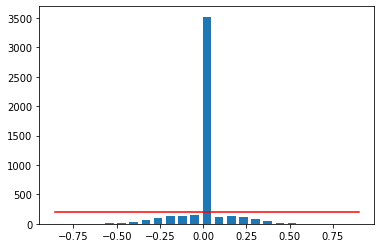

In [9]:
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)

# Since uaing bins for our histogram does not guarantee the center value to be 0
# (which just means we are driving straight), we want to have our values centered
# around 0. 
center = (bins[:-1] + bins [1:]) * 0.5
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), 
         (samples_per_bin, samples_per_bin), 'r-')

## Balancing Data

From the histogram above, we can see that the histogram has a lot of data with 0 angle (driving straight) which is due to the nature of our track. The left and right steering angles seemed to be pretty balanced Since we both in both opposing directions of the track.

Training the model based on this data creates a problem for the neural network which could bias the model towards predicting a zero angle. Thus the car becomes biased towards driving straight all the time; We rearely steer and become easily confused with sharp turns.

What can be done to improve this is reject all the samples above a certain threshold and make sure data is more uniform and not biased towards a specific steering angle.

**The red line from the histogram above is the threshold of the data points we want to take from the histogram**, This way, we can generalize the data more so that there would be more equal data between various steering angles.

But again, it is also essential to capture more zero steering angles as the track itself has a lot of straight roads.

In [10]:
print('total data: ', len(data))

remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    # Isolate steering angles belonging to the current bins being iterated through
    # if the steering angle falls between 2 bins, it belongs to the current interval bin j
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i) # appends the index of the data to the list.
    
  # Our data is arranged such that it is ordered from the beginning of our drive
  # to the end of our drive. Without shuffling, when we want to cut the amount of
  # data to a certain threshold, only the data at the end of our drive will be cut.
  # Therefore shuffling is important
  list_ = shuffle(list_)

  # cuts the list from index 200 (samples per bin) to the end 
  # This is where we want to cut extraneous data
  list_ = list_[samples_per_bin:]

  """
  Difference between append() and extend():
  - append() -> adds its argument as a single element to the end of a list. The length
    of the list itself will increase by one
  - extend() -> iterates over its argument adding each element to the list, xtending the list.
    The length of the list will increase by however many elements were in the iterable argument
  """
  remove_list.extend(list_)


print('removed', len(remove_list))

# set inplace equal to true so as to have the updated value remain on the same copy
data.drop(data.index[remove_list], inplace = True)

print('remaining', len(data))

total data:  4690
removed 3320
remaining 1370


## Plot the balanced data:

From the data below, now we can see that it is more balanced.

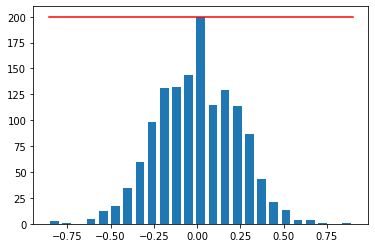

In [11]:
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), 
         (samples_per_bin, samples_per_bin), 'r-')

Note: would be better to add more data on "Recovery laps" where we steer the car to the edge of the track line and record it when we're trying to get back to the middle lane.

This extra data will help the car get back to the middle of the road when it starts to swerve out of the track

## Training and Validation Split

The image from the dataset will be the data that we use and the steering will be the label for the images.

In [12]:
# ilog allows us to perform a selection on a row of data from our data frame
# based on the specified index. below is a quick example of iloc
print(data.iloc[1])

def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    # join the path of the data directory with the image itself.
    # use .strip() to eliminate any spaces that maybe present in the string
    # Although there might not be any spaces in our data, it's good practice to have it
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_path = np.asarray(image_path)
  steering = np.asarray(steering)
  return image_path, steering

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2020_07_29_19_25_47_636.jpg
left        left_2020_07_29_19_25_47_636.jpg  
right       right_2020_07_29_19_25_47_636.jpg 
steering   -0.318333                          
throttle    1                                 
reverse     0                                 
speed       2.1245                            
Name: 12, dtype: object


In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size = 0.2, random_state = 5)
print('Training Sample : {}\nValidation Samples: {}'.format(len(X_train), len(X_valid)))

Training Sample : 1096
Validation Samples: 274


Plot the training and validation data distribution

Text(0.5, 1.0, 'Validation set')

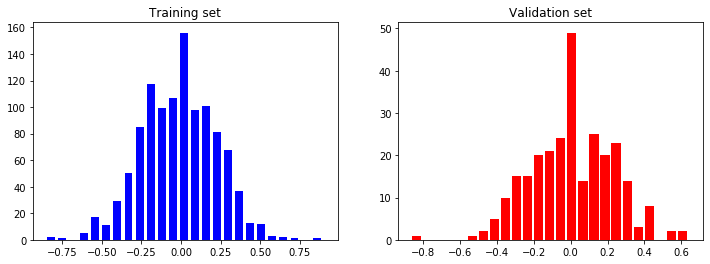

In [14]:
fig, axes = plt.subplots(1, 2, figsize = (12,4))
axes[0].hist(y_train, bins = num_bins, width = 0.05, color = 'blue')
axes[0].set_title("Training set")
axes[1].hist(y_valid, bins = num_bins, width = 0.05, color = 'red')
axes[1].set_title("Validation set")


## Preprocessing Images

- **Cropping the image**:
Our image might contain unneccesary details such as mountains and trees that we do not want to focus on. We would only want to focus the lanes for our image. Therefore, preprocessing the image is important.
- **Converting color of image**:
Since we will be using the Nvidia model to train our model, and the Nvidia model is absed off the YUV color map instead of RGB
  - **Y** : Luminosity or brightness of the image
  - **U V** : Chromium of the image
- **Gaussian Blur** : Helps smoothing the image and reduce noise within the image
- **Decrease Image Size** : Less computational power for smaller image pixels. in this case, we want to resize the image to 200x66 since it matches the nvidia model.

In [15]:
def img_preprocess(img):
  img = mpimg.imread(img)
  img = img[60:135, :, :]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255 # Normalizing the image
  return img

Plot the preprocessed image side by side with the original image:

Text(0.5, 1, 'Preprocessed Image')

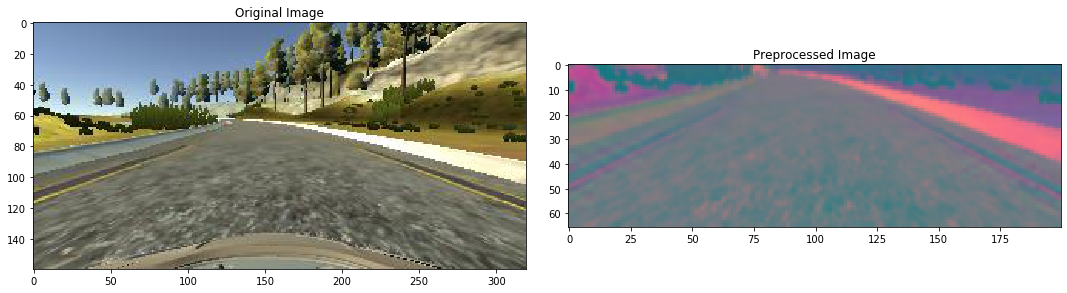

In [16]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axs = plt.subplots(1, 2, figsize = (15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')


In [17]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))

(1096, 66, 200, 3)


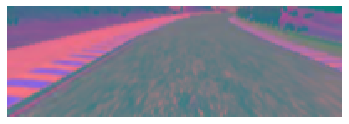

In [18]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis("off")
print(X_train.shape)